In [1]:
import pandas as pd
import os
import seaborn as sns
import statsmodels
import numpy as np
from pathlib import Path
from datetime import datetime
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

#### Read in data

In [3]:
data_path = "D:\\Users\\Nicholas\\Projects\\repos\\spc_charts\\data\\raw\\diabetes\\Diabetes-Data"

In [4]:
data_files = [i for i in os.listdir(data_path) if 'data-' in i]

In [5]:
def read_data(path):
    data = pd.read_table(path, header=None)
    data.columns = ['Date', 'Time', 'Code', 'Value']
    return data

In [6]:
data = pd.DataFrame(columns = ['Date', 'Time', 'Code', 'Value'])

for i in range(len(data_files)):
    temp = read_data(Path(data_path) / data_files[i])
    data = data.append(temp, ignore_index=True)

#### Subset data to blood glucose measurement

In [7]:
data_sub = data.loc[data['Code'].isin([48, 57, 58, 59, 60, 61, 62, 63, 64]), :].copy()

In [8]:
data_sub['Date'] = data_sub['Date'] + ' ' + data_sub['Time'] 

In [9]:
data_sub['Date'] = pd.to_datetime(data_sub['Date'], errors='coerce')

In [10]:
data_sub['Value'] = pd.to_numeric(data_sub['Value'], errors='coerce')

In [11]:
data_sub = data_sub.dropna()

#### Aggregate by date

In [12]:
data_sub_day = data_sub.groupby(pd.Grouper(key='Date', freq='d')).agg(mean = ('Value', 'mean'), 
                                                                      sd = ('Value', 'std'),
                                                                      n = ('Value', 'count'))

In [13]:
data_sub_day = data_sub_day.dropna()

In [14]:
data_sub_day = data_sub_day.reset_index()

#### Subset data to a smaller set

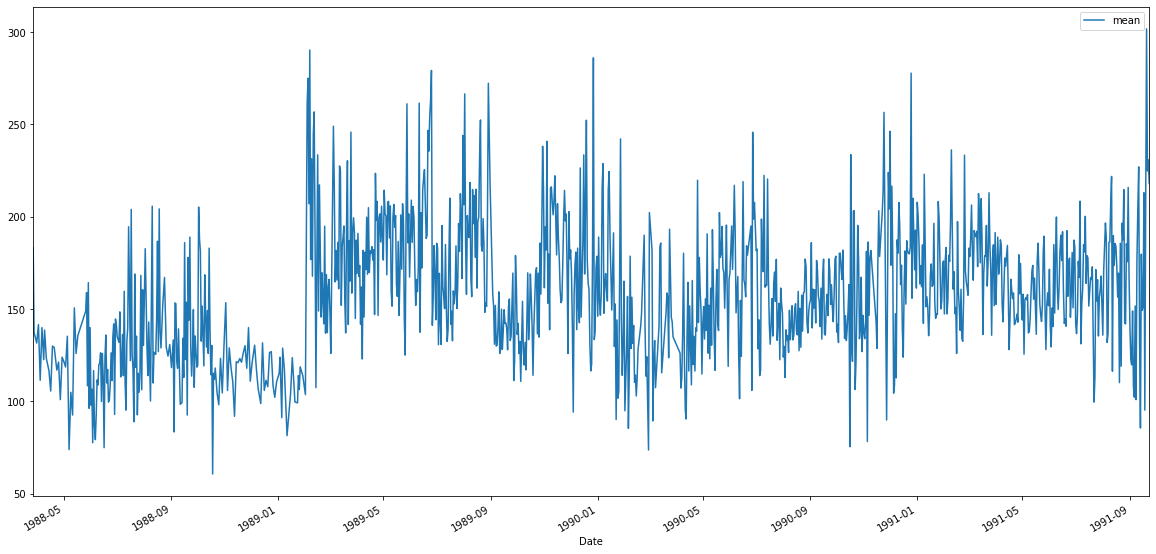

In [15]:
data_sub_day.plot.line(x='Date', y='mean', figsize=(20,10))

In [16]:
date_filter = (data_sub_day['Date'] >= '1989-09') & (data_sub_day['Date'] < '1989-11-06')

In [17]:
date_cutoff = '1989-10-15'

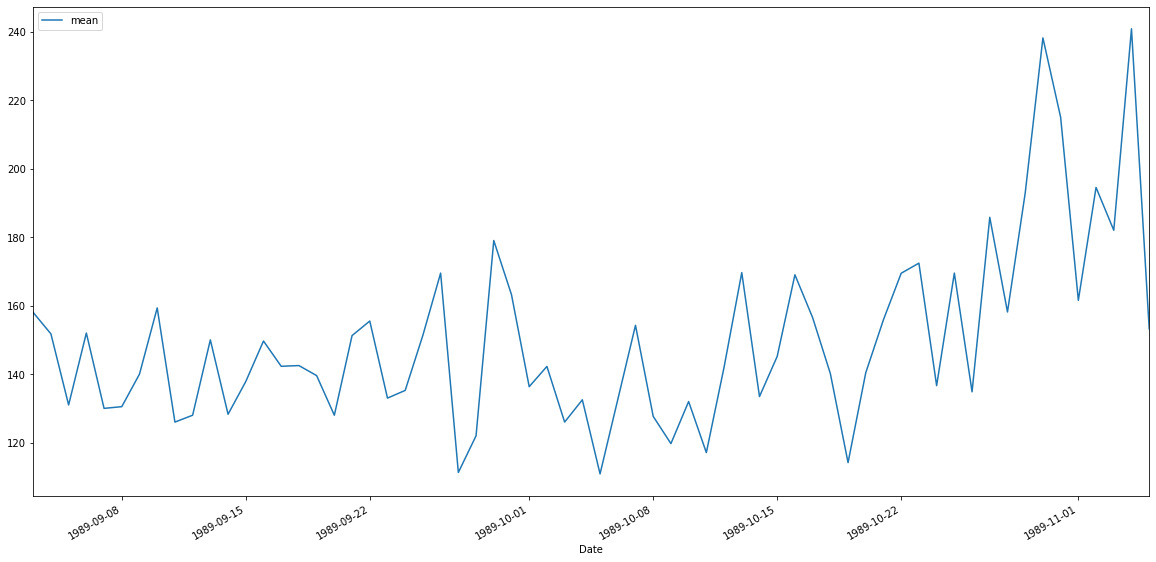

In [18]:
data_sub_day[date_filter].plot.line(x='Date', y='mean', figsize=(20,10))

In [19]:
data_sub_day = data_sub_day[date_filter].copy()

#### Hypothesis test

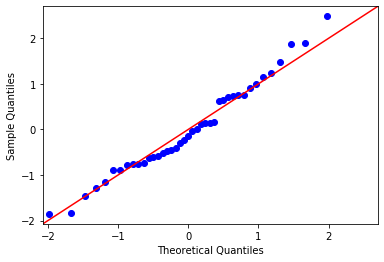

In [20]:
fig = sm.qqplot(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'], fit=True, line='45')
plt.show()

In [21]:
def shapiro_wilks_(data, alpha):
    
    # Imports
    from scipy.stats import shapiro
    
    # normality test
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    # interpret
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [22]:
shapiro_wilks_(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'], alpha=0.05)

Statistics=0.976, p=0.535
Sample looks Gaussian (fail to reject H0)


In [23]:
def jarque_bera_(data, alpha):
    
    # imports
    import statsmodels
    
    # normality test
    stat, p, skew, kurt = statsmodels.stats.stattools.jarque_bera(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    
    # interpret
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [24]:
jarque_bera_(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'], alpha=0.05)

Statistics=1.147, p=0.564
Sample looks Gaussian (fail to reject H0)


In [25]:
acorr_ljungbox(data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'], lags=10)

(array([ 0.01541998,  5.09507399,  5.85158314,  6.34077097,  6.58469957,
         6.62325803,  6.98398633,  7.02720509,  9.99540879, 10.06754489]),
 array([0.90117496, 0.07827422, 0.11905858, 0.17510368, 0.25340325,
        0.35709638, 0.4305491 , 0.53370031, 0.35085703, 0.43458747]))

#### Get in control mean

In [26]:
# Get in-control mean
data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'].mean()

139.99635202196174

In [27]:
in_control_mean = data_sub_day.loc[data_sub_day['Date'] < date_cutoff, 'mean'].mean()

#### Calculate moving range

In [28]:
data_sub_day['MR'] = data_sub_day['mean'].rolling(window=2).apply(lambda x: x.max() - x.min(), raw=True)

In [29]:
x_ind_df = data_sub_day.copy()

In [30]:
def x_ind_params(mu0, sigma, length, L=3):
    
    # params
    UCL = mu0 + L * sigma
    center = mu0
    LCL = mu0 - L * sigma
    
    ret = pd.DataFrame({
        'UCL':UCL,
        'Center':center,
        'LCL':LCL
    }, index=list(range(length)))
    
    return ret    

In [31]:
x_ind_params_df = x_ind_params(mu0=in_control_mean, sigma = x_ind_df['MR'].mean() / 1.128, length = len(x_ind_df['mean']))

In [32]:
x_ind_df = pd.concat([x_ind_df.reset_index(drop=True), x_ind_params_df.reset_index(drop=True)], axis=1)

Text(0, 0.5, 'X')

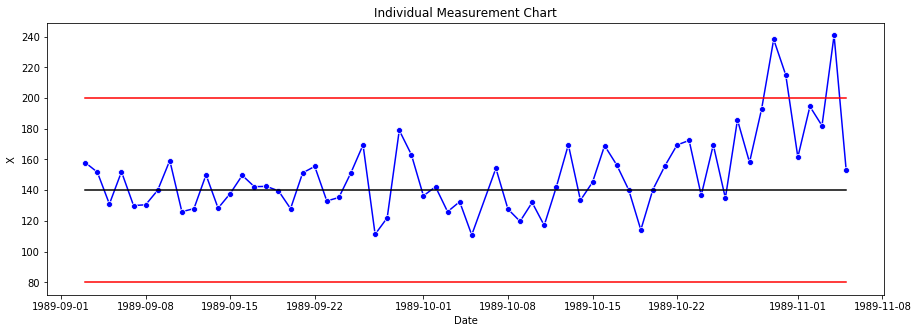

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='mean', data=x_ind_df, kind='line', ax=ax, color='blue', marker='o')
sns.lineplot(x='Date', y='UCL', data=x_ind_df, drawstyle='steps-pre', ax=ax, color='red')
sns.lineplot(x='Date', y='LCL', data=x_ind_df, drawstyle='steps-pre', ax=ax, color='red')
sns.relplot(x='Date', y='Center', data=x_ind_df, kind='line', ax=ax, color='black')
plt.close()
plt.close()
plt.title('Individual Measurement Chart')
plt.ylabel('X')

In [34]:
x_ind_df['Date'][x_ind_df['mean'] > x_ind_df['UCL'][-1:].values[0]].reset_index(drop=True)[0]

Timestamp('1989-10-30 00:00:00')

#### Calculate EWMA

In [35]:
def ewma(arg, alpha=0.1, mu0=None):
    
    if mu0 is None: 
        arg_temp = arg.copy().tolist()
        
    else:
        arg_temp = arg.copy().tolist()
        arg_temp.insert(0, mu0)
    
    # Convert list to series
    arg_series = pd.Series(arg_temp)
    
    # calculate offset: if mu0=None, offset=0, else offset=1
    offset = len(arg_series) - len(arg)
    
    # Return ewma
    ret = arg_series.ewm(alpha=alpha, adjust=False).mean()[offset:].tolist()
    
    return ret

In [36]:
def ewma_params(mu0, sigma, length, alpha=0.1, L=3):
    
    # Set up the index
    i = pd.Series(list(range(1, length+1)))
    
    # params
    UCL = mu0 + L * sigma * np.sqrt((alpha / (2-alpha)) * (1 - (1-alpha)**(2*i)))
    center = mu0
    LCL = mu0 - L * sigma * np.sqrt((alpha / (2-alpha)) * (1 - (1-alpha)**(2*i)))
    
    ret = pd.DataFrame({
        'UCL':UCL,
        'Center':center,
        'LCL':LCL
    })
    
    return ret

In [37]:
ewma_df = data_sub_day.copy()

In [38]:
ewma_df['ewma'] = ewma(data_sub_day['mean'], mu0=in_control_mean)

In [39]:
ewma_params_df = ewma_params(mu0 = in_control_mean, sigma = ewma_df['MR'].mean() / 1.128, length=len(ewma_df['mean']))

In [40]:
ewma_df = pd.concat([ewma_df.reset_index(drop=True), ewma_params_df.reset_index(drop=True)], axis=1)

Text(0, 0.5, 'EWMA')

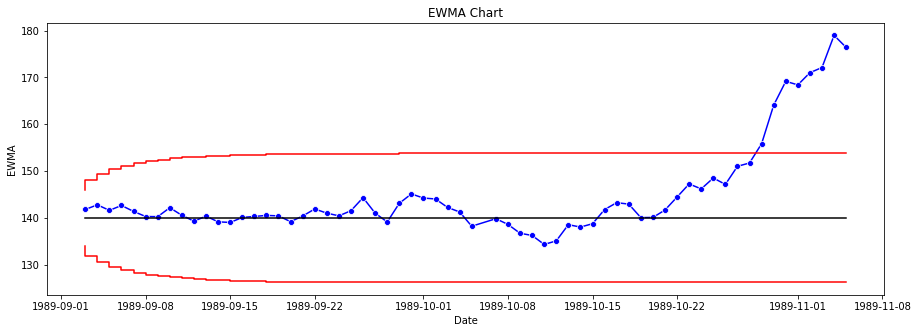

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='ewma', data=ewma_df, kind='line', ax=ax, color='blue', marker='o')
sns.lineplot(x='Date', y='UCL', data=ewma_df, drawstyle='steps-pre', ax=ax, color='red')
sns.lineplot(x='Date', y='LCL', data=ewma_df, drawstyle='steps-pre', ax=ax, color='red')
sns.relplot(x='Date', y='Center', data=ewma_df, kind='line', ax=ax, color='black')
plt.close()
plt.close()
plt.title('EWMA Chart')
plt.ylabel('EWMA')

In [42]:
ewma_df['Date'][ewma_df['ewma'] > ewma_df['UCL'][-1:].values[0]].reset_index(drop=True)[0]

Timestamp('1989-10-29 00:00:00')

#### Calculate cusum

In [43]:
def cusum(arg, mu0=None):
    
    if mu0 is None: 
        mu0 = arg.mean()
        
    # Calculate deviation
    dev = arg - mu0
    
    # Calculate cusum
    cusum = dev.cumsum()
    
    return cusum

In [44]:
cusum_df = data_sub_day.copy()

In [45]:
cusum_df['cusum'] = cusum(cusum_df['mean'], mu0=in_control_mean)

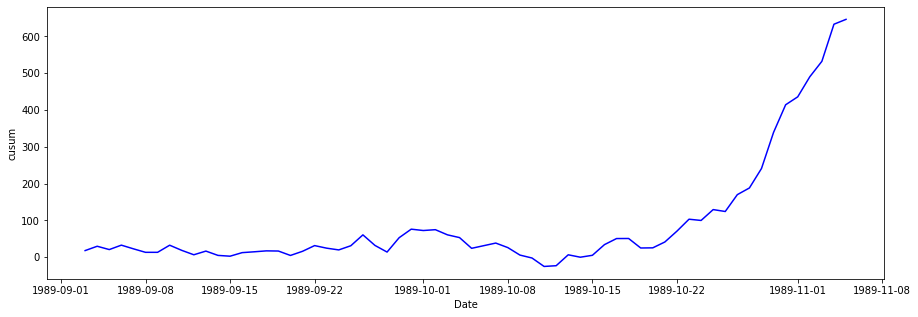

In [46]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='cusum', data=cusum_df, kind='line', ax=ax, color='blue')
plt.close()

#### Tabular cusum

In [47]:
def tab_cusum(arg, mu0, sigma, k=0.5, h=4):
    
    # Set up parameters
    K = k * sigma
    H = h * sigma
    
    tol_pos = mu0 + K
    tol_neg = mu0 - K
    
    dev_pos = (arg - tol_pos).tolist()
    dev_neg = (tol_neg - arg).tolist()
    
    C_pos = [0] * (len(arg) + 1)
    C_neg = [0] * (len(arg) + 1)
    
    # Start loop
    for i in range(1, (len(arg) + 1)):

        C_pos[i] = np.max([0, dev_pos[i-1] + C_pos[i-1]])
        C_neg[i] = np.max([0, dev_neg[i-1] + C_neg[i-1]])
    
    ret = pd.DataFrame({
        'C_pos':C_pos,
        'C_neg':C_neg,
        'UCL':H
    })
    
    ret = ret.iloc[1:, ]
    ret['C_neg'] = -1 * ret['C_neg']
    ret['LCL'] = -1 * ret['UCL']
#     ret['xi'] = arg.tolist()
    
    return(ret)

In [48]:
tab_cusum_df = data_sub_day.copy()

In [49]:
tab_cusum_params_df = tab_cusum(tab_cusum_df['mean'], mu0=in_control_mean, sigma=tab_cusum_df['MR'].mean() / 1.128)

In [50]:
tab_cusum_df = pd.concat([tab_cusum_df.reset_index(drop=True), tab_cusum_params_df.reset_index(drop=True)], axis=1)

Text(0, 0.5, 'Cusum')

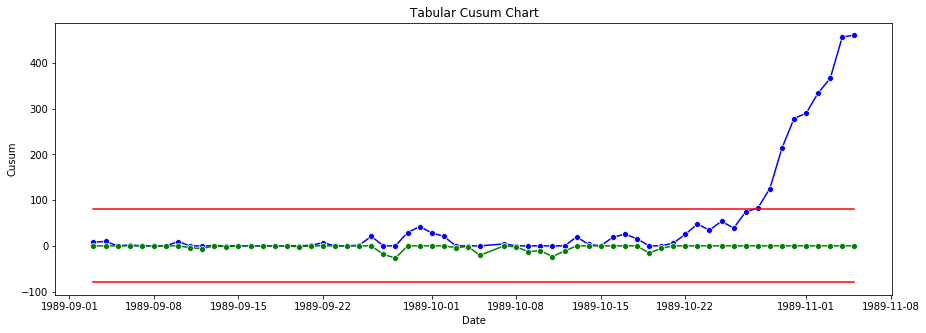

In [51]:
fig, ax = plt.subplots(figsize=(15,5))
sns.relplot(x='Date', y='C_pos', data=tab_cusum_df, kind='line', ax=ax, color='blue', marker='o')
sns.relplot(x='Date', y='C_neg', data=tab_cusum_df, kind='line', ax=ax, color='green', marker='o')
sns.lineplot(x='Date', y='UCL', data=tab_cusum_df, drawstyle='steps-pre', ax=ax, color='red')
sns.lineplot(x='Date', y='LCL', data=tab_cusum_df, drawstyle='steps-pre', ax=ax, color='red')
plt.close()
plt.close()
plt.title('Tabular Cusum Chart')
plt.ylabel('Cusum')

In [52]:
tab_cusum_df['Date'][tab_cusum_df['C_pos'] > tab_cusum_df['UCL'][-1:].values[0]].reset_index(drop=True)[0]

Timestamp('1989-10-28 00:00:00')